In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import os


## score functions

In [15]:
def score_GVP(dy, ceil = 2.):
    gvp = (1.0 + (dy/5.0)**2)**0.5 - 1.0
    res = np.clip(gvp, 0., ceil) # if gvp < ceil {gvp} else {ceil};
    return 100.*res


In [22]:
data = "CGM_p77_24h"
diff = "CGMDIFF"+data[3:]

df = pd.read_csv("data/%s.csv"%data, header=None, names=["ts","CGM"])
df["TIR"] = df["CGM"].apply(lambda x: 100.0 if ((x<180) & (x>70)) else 0.0)
df["H70"] = df["CGM"].apply(lambda x: 100.0 if (x<70) else 0.0)
df["H54"] = df["CGM"].apply(lambda x: 100.0 if (x<54) else 0.0)
df["GVP"] = df["CGM"].diff(1).apply(score_GVP)
df["LOG"] = df["CGM"].apply(lambda x: 200.*(np.log(np.clip(x,20,400))/np.log(20)-1))
df["ADV"] = df["CGM"].diff(1).apply(np.abs)
df["LOG_ADV"] = df["LOG"].diff(1).apply(np.abs)
df["SIX"] = df["CGM"].apply(lambda x: 200.*(np.log(np.clip(x,36,216))/np.log(6)-2))
df["SIX_ADV"] = df["SIX"].diff(1).apply(np.abs)
df["SJU"] = df["CGM"].apply(lambda x: 200.*(np.log(np.clip(x,49,343))/np.log(7)-2))
df["SJU_ADV"] = df["SJU"].diff(1).apply(np.abs)
df["SJU_ADV50"] = df["SJU"].diff(1).clip(-50.,50.).apply(np.abs)
df["DIFF"] = pd.read_csv("data/%s.csv"%diff, header=None, index_col=0).values
df["ABS50"] = df["DIFF"].clip(-50.,50.).apply(np.abs)
df["RDV"] = df["DIFF"].apply(lambda x: 10*score_GVP(x, 10)/100)

df.head()


,ts,CGM,TIR,H70,H54,GVP,LOG,ADV,LOG_ADV,SIX,SIX_ADV,SJU,SJU_ADV,SJU_ADV50,DIFF,ABS50,RDV
0,2021-01-01 12:18:40,189.000000,0.0,0.0,0.0,NaN,149.947628,NaN,NaN,185.094942,NaN,138.745020,NaN,NaN,5.993355,5.993355,5.610293
1,2021-01-01 12:23:40,194.993355,0.0,0.0,0.0,56.102927,152.031824,5.993355,2.084196,188.579614,3.484672,141.953644,3.208624,3.208624,-1.993355,1.993355,0.765401
2,2021-01-01 12:28:40,193.000000,0.0,0.0,0.0,7.654013,151.345829,1.993355,0.685996,187.432664,1.146950,140.897553,1.056091,1.056091,5.980000,5.980000,5.589792
3,2021-01-01 12:33:40,198.980000,0.0,0.0,0.0,55.897915,153.383002,5.980000,2.037173,190.838716,3.406052,144.033785,3.136232,3.136232,-5.973333,5.973333,5.579565
4,2021-01-01 12:38:40,193.006667,0.0,0.0,0.0,55.795650,151.348135,5.973333,2.034867,187.436519,3.402196,140.901103,3.132682,3.132682,2.003333,2.003333,0.772807


## analyse hourly averages

In [23]:
dfh = df.groupby(df.index//12).mean()


In [29]:
allfiles = glob("data/*/%s*hourly.csv"%data) + glob("data/*/%s*hourly.csv"%diff)

dth = {"CGM": {}}
#dt = {key:{} for key in df.columns[1:]}

for filepath in allfiles:
    _, keys, filename = filepath.split("/")
    name, _ = filename.split(".")
    tmp = name.split("_")
    tag = keys+"_"+"_".join(tmp[3:6])
    idx = "_".join(tmp[6:-1])
    if "DIFF" in name:
        idx = idx + "_DIFF"
    if idx not in dth.keys():
        dth[idx] = {}
    #print(tag, idx)
    dth[idx][tag] = pd.read_csv(filepath, header=None).values[:,0]
            
{key:len(dth[key]) for key in dth.keys()}


{'CGM': 42,
 'LOG_CGM': 9,
 'TIR_CGM': 22,
 'SJU_CGM': 22,
 'ADV_CGM': 22,
 'SJU_ADV_CGM': 19,
 'SIX_CGM': 22,
 'GVP_CGM': 22,
 'SJU_ADV50_CGM': 19,
 'SIX_ADV_CGM': 1,
 'LOG_ADV_CGM': 1,
 'H54_CGM': 1,
 'H70_CGM': 1,
 'CGM_DIFF': 14,
 'ABS50_CGM_DIFF': 14,
 'RDV_CGM_DIFF': 14}

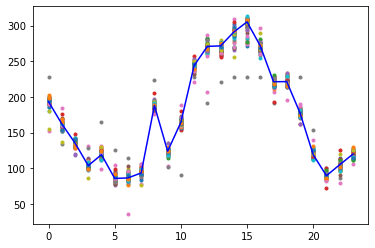

,mean,std,25%,75%,rmse,rel
80_1024_1_3_7_2_3_400,-0.675063,3.848346,-4.002941,1.567224,3.907106,0.022529
80_1024_1_5_4_3_3_400,-0.540102,3.869809,-2.427048,2.508582,3.907317,0.022531
80_1024_1_5_7_2_3_400,0.918081,3.991984,-1.609323,3.105829,4.096194,0.023620
80_1024_1_7_4_2_3_400,-1.526580,3.819263,-3.233876,1.605692,4.113054,0.023717
80_1024_1_4_7_2_3_400,-1.356461,3.883163,-4.219869,1.492809,4.113265,0.023718
80_1024_1_4_5_2_3_400,-0.072568,4.128588,-2.380516,2.243559,4.129226,0.023810
80_1024_1_6_4_3_3_400,-2.036384,3.722319,-4.564479,0.734033,4.242938,0.024466
80_1024_1_6_6_2_3_400,-0.144848,4.250794,-2.325927,2.503307,4.253261,0.024525
80_1024_1_6_6_3_3_400,-0.676350,4.239903,-4.097041,2.627657,4.293510,0.024757
80_1024_1_5_6_3_3_400,-0.442178,4.431291,-4.087071,2.968095,4.453298,0.025679


In [30]:
idx = "CGM"
ds = pd.DataFrame(dth[idx], index=None)
plt.plot(ds, ".")
plt.plot(dfh[idx], "b")
plt.show()
tmp = (ds - dfh[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


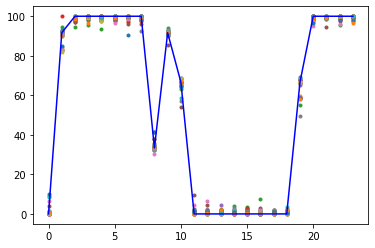

,mean,std,25%,75%,rmse,rel
80_1024_1_4_6_2_3_400,0.293645,1.084430,-0.063316,1.063206,1.123484,0.019973
80_1024_1_6_5_2_3_400,0.154131,1.195396,-0.127579,0.520885,1.205291,0.021427
80_1024_1_6_3_2_3_400,-0.043375,1.294976,-1.083930,0.903570,1.295702,0.023035
80_1024_1_6_7_2_3_400,-0.318883,1.836150,-0.914132,0.478328,1.863634,0.033131
80_1024_1_6_4_2_3_400,0.035859,1.928066,0.000000,0.986341,1.928400,0.034283
80_1024_1_5_4_2_3_400,0.448783,1.961574,-0.355249,1.307021,2.012257,0.035773
80_1024_1_7_3_2_3_400,0.423154,2.009336,-0.102255,0.422905,2.053410,0.036505
80_1024_1_4_7_2_3_400,-0.302976,2.049879,-0.701463,0.924929,2.072148,0.036838
80_1024_1_7_6_2_3_400,-0.520840,2.081003,-0.924689,0.265705,2.145192,0.038137
80_1024_1_3_7_2_3_400,-0.063128,2.211433,-0.730326,1.351253,2.212333,0.039330


In [33]:
idx = "TIR"
ds = pd.DataFrame(dth[idx+"_CGM"], index=None)
plt.plot(ds, ".")
plt.plot(dfh[idx], "b")
plt.show()
tmp = (ds - dfh[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


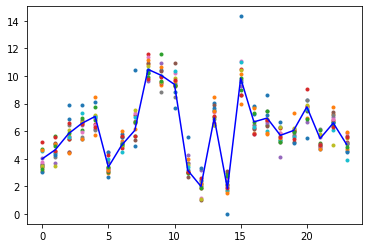

,mean,std,25%,75%,rmse,rel
80_1024_1_6_4_2_3_50,0.025452,0.441055,-0.203629,0.282145,0.441789,0.072369
80_1024_1_5_4_2_3_50,0.043134,0.505584,-0.370493,0.210822,0.507421,0.083120
80_1024_1_5_7_2_3_50,-0.022083,0.583235,-0.362906,0.513955,0.583653,0.095608
80_1024_1_5_5_2_3_50,-0.019323,0.601018,-0.390228,0.045614,0.601329,0.098503
80_1024_1_6_5_2_3_50,0.015121,0.616237,-0.381315,0.573567,0.616422,0.100975
80_1024_1_4_6_2_3_50,0.089600,0.613108,-0.314569,0.480382,0.619621,0.101499
80_1024_1_6_7_2_3_50,-0.014118,0.626134,-0.344704,0.250864,0.626293,0.102592
80_1024_1_4_5_2_3_50,0.019045,0.659778,-0.419102,0.536047,0.660053,0.108123
80_1024_1_6_3_2_3_50,0.171436,0.642241,-0.254001,0.781893,0.664729,0.108888
80_1024_1_4_7_2_3_50,0.054977,0.682758,-0.169293,0.414268,0.684967,0.112204


In [31]:
idx = "ABS50"
ds = pd.DataFrame(dth[idx+"_CGM_DIFF"], index=None)
plt.plot(ds, ".")
plt.plot(dfh[idx], "b")
plt.show()
tmp = (ds - dfh[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


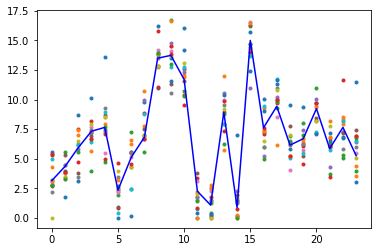

,mean,std,25%,75%,rmse,rel
80_1024_1_6_3_2_3_50,0.047783,0.929730,-0.181984,0.701146,0.930957,0.133187
80_1024_1_4_7_2_3_50,0.030817,1.137965,-0.811645,0.794725,1.138382,0.162862
80_1024_1_5_6_2_3_50,0.025467,1.208161,-0.670291,1.009918,1.208429,0.172884
80_1024_1_5_7_2_3_50,-0.176489,1.204945,-0.789456,0.546548,1.217802,0.174225
80_1024_1_6_7_2_3_50,0.376240,1.167370,-0.725208,1.088374,1.226503,0.175469
80_1024_1_6_4_2_3_50,-0.326300,1.296990,-0.922289,0.355369,1.337406,0.191336
80_1024_1_6_6_2_3_50,0.062673,1.397751,-0.381852,0.787410,1.399155,0.200170
80_1024_1_6_5_2_3_50,-0.086139,1.443196,-1.091378,1.251757,1.445765,0.206838
80_1024_1_5_5_2_3_50,-0.304245,1.426295,-1.070874,0.500554,1.458384,0.208643
80_1024_1_5_4_2_3_50,-0.149076,1.458935,-1.138582,0.938815,1.466531,0.209809


In [32]:
idx = "RDV"
ds = pd.DataFrame(dth[idx+"_CGM_DIFF"], index=None)
plt.plot(ds, ".")
plt.plot(dfh[idx], "b")
plt.show()
tmp = (ds - dfh[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")


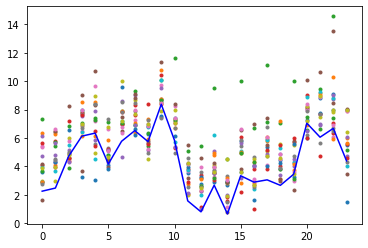

,mean,std,25%,75%,rmse,rel
80_1024_1_6_5_2_3_400,0.997744,1.024879,0.492420,1.593216,1.430339,0.331008
80_1024_1_4_6_2_3_400,1.022561,1.074806,0.268817,1.873529,1.483523,0.343316
80_1024_1_7_5_2_3_400,1.078673,1.102933,0.263358,1.645112,1.542723,0.357016
80_1024_1_7_4_2_3_400,1.167337,1.084217,0.556058,1.493073,1.593173,0.368691
80_1024_1_6_6_2_3_400,1.152838,1.115598,0.465326,1.815752,1.604243,0.371253
80_1024_1_7_7_2_3_400,0.963440,1.316254,-0.141728,2.038911,1.631179,0.377486
80_1024_1_6_4_2_3_400,1.219828,1.106172,0.549414,1.973626,1.646693,0.381077
80_1024_1_5_4_2_3_400,1.144703,1.248710,0.120406,2.051786,1.693996,0.392024
80_1024_1_5_5_2_3_400,1.248613,1.199611,0.685718,2.030138,1.731502,0.400703
80_1024_1_5_6_2_3_400,1.121432,1.343551,0.137953,2.061209,1.750068,0.405000


In [36]:
idx = "SJU_ADV50"
ds = pd.DataFrame(dth[idx+"_CGM"], index=None)
plt.plot(ds, ".")
plt.plot(dfh[idx], "b")
plt.show()
tmp = (ds - dfh[[idx]].values).describe().T[["mean","std","25%","75%"]]
tmp["rmse"] = (tmp["std"]**2+tmp["mean"]**2)**0.5
tmp["rel"] = tmp["rmse"]/df[idx].mean()
tmp.sort_values("rel")
